# Analysis of StableSwap Capital Efficiency, ETH-stETH pool on Ethereum, Curve.fi

We compute capital efficiency of the ETH-stETH pool on Curve.fi (Ethereum) compared to a concentrated liquidity pool. We use `[0.8, 1.0]` as the range of stETH/ETH (i.e., stETH denoted in units of ETH) prices.

https://curve.fi/#/ethereum/pools/steth/swap

Data pulled: 2022-11-28 directly from the pool contract.

# Early Setup

Some code that has to run first

In [1]:
# Increase precision (from 53). Has to be the first thing in the file.
# (turns out to be unimportant for the result but we leave it in just to be sure)
RealNumber = RealField(300, sci_not=True)

In [2]:
load('stableswap.sage')

In [3]:
# Output helper:
def alln(*args):
    """x.n() or map over them."""
    if len(args) == 1:
        (x,) = args
        if isinstance(x, (list, tuple, set)):
            return type(x)(map(alln, x))
        return x.n()
    return tuple(alln(a) for a in args)

# Pool Model

In [4]:
# We swap the two assets because we want to use ETH as the numéraire and
# it's more natural to use asset y for that.
asset_labels = "stETH ETH".split()

balances = [
    389250551143646596926245 / 1e18,
    208191152501595956439752 / 1e18
]

a_val = 50

# For info
alln(balances)

[389250.551143647, 208191.152501596]

In [5]:
init_stableswap(2)

In [6]:
d_sln = stableswap_get_d(balances, a_val)
d_sln

597143.0371172205

In [7]:
# y (ETH) as a fct of x (stETH). We also replace the variable t0 by x.
# Note: We just know that solution [1] is the right one; we do a sanity
# check below.
var('x')
y_x = t1.subs(solve(eq_stableswap.subs(a=a_val, d=d_sln), t1)[1])
y_x = y_x.subs(t0=x)

In [8]:
# Sanity check: These should match.
alln(y_x.subs(x=balances[0]), balances[1])

(208191.152501596, 208191.152501596)

In [9]:
# price of asset x as a fct of x
px_x = -y_x.diff()

# Capital Efficiency Computation

In [10]:
px_expd_range = (0.8, 1.0)  # x/y = stETH/ETH

In [11]:
# Compute reserve values at the upper and lower price point
x_px_low = find_root(px_x==px_expd_range[0], 0, 1e8)
y_px_low = y_x.subs(x==x_px_low)
x_px_high = find_root(px_x==px_expd_range[1], 0, 1e8)
y_px_high = y_x.subs(x==x_px_high)

In [12]:
# For information
matrix([
    [x_px_low, y_px_low],
    balances,
    [x_px_high, y_px_high]
]).apply_map(lambda x: x.n())

[564151.890123331 41401.0466645413]
[389250.551143647 208191.152501596]
[298571.518558611 298571.518558609]

In [13]:
px_now = px_x.subs(x=balances[0])
px_now.n()

0.992775873666838

**Capital efficiency result:**

The following shows the amount of assets inefficiently allocated in the pool. These are the assets that are currently in the pool and would never leave the pool if the price stays within our expected price range. Higher is worse. We express these in percent of current balances.

In [14]:
print(f"% {asset_labels[0]} reserved for prices > {px_expd_range[1]:.2f} = {(x_px_high/balances[0]*100):.2f} %")
print(f"% {asset_labels[1]} reserved for prices < {px_expd_range[0]:.2f} = {(y_px_low/balances[1]*100).n():.2f} %")

% stETH reserved for prices > 1.00 = 76.70 %
% ETH reserved for prices < 0.80 = 19.89 %


Interpretation i.t.o. portfolio value (at *current* prices):

In [15]:
# Numeraire = asset y = ETH
pfvalue_now = balances[0] * px_now + balances[1]
pfvalue_inefficient = x_px_high * px_now + y_px_low
pfvalue_inefficient_rel = pfvalue_inefficient / pfvalue_now
print(f"Portfolio value reserved for prices outside [{px_expd_range[0]:.2f}, {px_expd_range[1]:.2f}]: "+
      f"{pfvalue_inefficient.n():,.0f} ({asset_labels[1]}) of {pfvalue_now.n():,.0f} ({asset_labels[1]}) = {pfvalue_inefficient_rel.n()*100:.2f}%"
     )

Portfolio value reserved for prices outside [0.80, 1.00]: 337,816 (ETH) of 594,630 (ETH) = 56.81%


# Plots / Intuition

We can build some intuition using a plot. First of the trading curve itself, then of the price curve. Note that it is hard to see small price (tangent slope) differences visually when only looking at the trading curve; that's why the price curve is quite useful.

In the following, the grid lines mark the two ends of the price range.

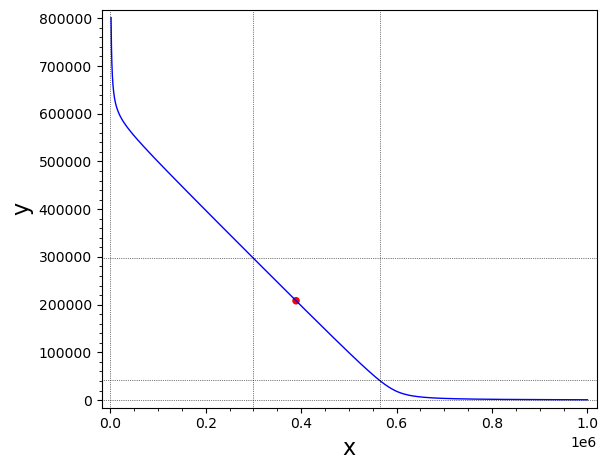

In [16]:
p1 = plot(y_x, x, 0, 1e6, aspect_ratio=1, axes=False, frame=True, ymin=0,
         gridlines=[[0, x_px_low, x_px_high],[0, y_px_low, y_px_high]],
         plot_points=500, adaptive_recursion=50,
         axes_labels=["x", "y"]
        )
# p2 = point((balances_meta_scaled[0], corresp_balances_base[1]), color="red", size=25)
p3 = point(balances, color="red", size=30)
show(p1 + p3)

^^ We immediately see, perhaps not surprisingly, that half of the trading curve is cut off.

### Price plot of px as a fct of x

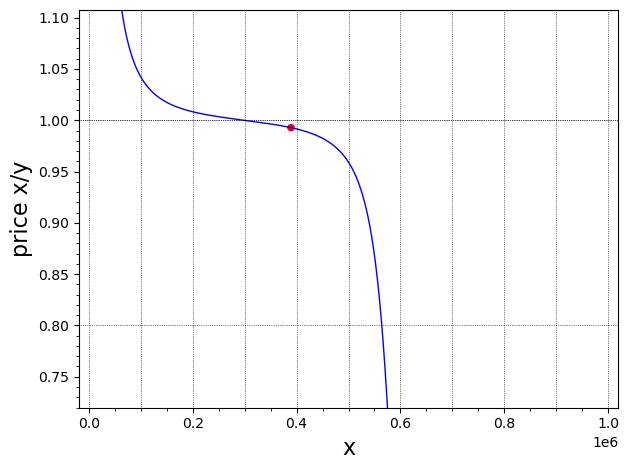

In [17]:
g = Graphics()
g += plot(px_x, x, 0, 1e6,
    ymin=px_expd_range[0]/1.1,
    ymax=px_expd_range[1]*1.1,
    gridlines=[[k * 1e6 for k in srange(0, 1.2, 0.1, include_endpoint=True)], [0,1]+list(px_expd_range)],
    axes_labels=["x", "price x/y"],
    axes=False, frame=True,
    plot_points=1000,
    adaptive_recursion=100,
)
g += point((balances[0], px_now), color="red", size=30)
show(g)

^^ Clearly, we're moving out of the price range very quickly as we bring x down. Any x amount below that intersection point is never sold if the price stays within the bounds.

### Price plot of px as a fct of y

In [18]:
var('y')
x_y = t0.subs(solve(eq_stableswap.subs(a=a_val, d=d_sln), t0)[1])
x_y = x_y.subs(t1=y)

In [19]:
# Sanity check, should match
alln(x_y.subs(y=balances[1]), balances[0])

(389250.551143646, 389250.551143647)

In [20]:
# We still want the price of x, but as a fct of y.
px_y = px_x.subs(x=x_y)

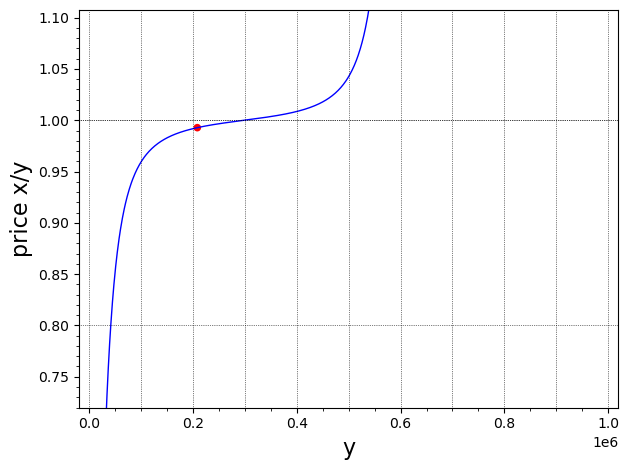

In [21]:
g = Graphics()
g += plot(px_y, y, 0, 1e6,
    ymin=px_expd_range[0]/1.1,
    ymax=px_expd_range[1]*1.1,
    gridlines=[[k * 1e6 for k in srange(0, 1.2, 0.1, include_endpoint=True)], [0,1]+list(px_expd_range)],
    axes_labels=["y", "price x/y"],
    axes=False, frame=True,
    plot_points=1000,
    adaptive_recursion=100,
)
g += point((balances[1], px_now), color="red", size=30)
show(g)

^^ The y direction / lower end of the price range isn't quite as bad, but we're still leaving a significant amount of y on the table.